In [1]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour

import category_encoders as ce

plt.style.use('seaborn-colorblind')
%matplotlib inline

In [3]:
use_cols = [
    'age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race',
    'sex','capital-gain','capital-loss','hours-per-week','native-country','makes_over_50K_a_year'
]

df = pd.read_csv('data/adult.data', names = use_cols, sep=', ')
df.to_csv("feature_engineering.csv", sep=',')
print(df.shape)
df.head(5)

/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,makes_over_50K_a_year
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Проверим пропущенные значения

In [4]:
def check_missing(df,output_path=None):    
    result = pd.concat([df.isnull().sum(),df.isnull().mean()],axis=1)
    result = result.rename(index=str,columns={0:'total missing',1:'proportion'})
    if output_path is not None:
        result.to_csv(output_path+'missing.csv')
        print(output_path, 'missing.csv')
    return result

In [5]:
check_missing(df=df)

,total missing,proportion
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education-num,0,0.0
marital-status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0
sex,0,0.0


ееее, их нет

## Выбросы

In [8]:
not_null_columns = []
for j in df.select_dtypes(exclude=['object']).columns.values:
    not_null_columns.append(j)
print(not_null_columns)

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


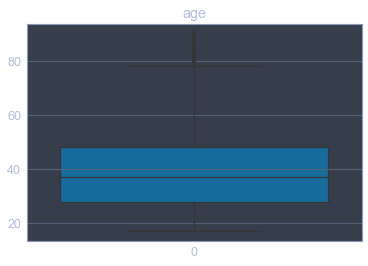

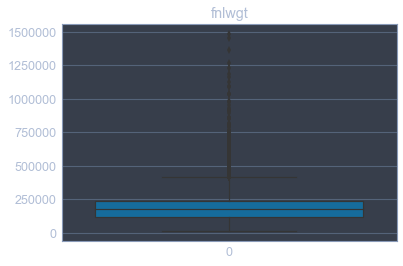

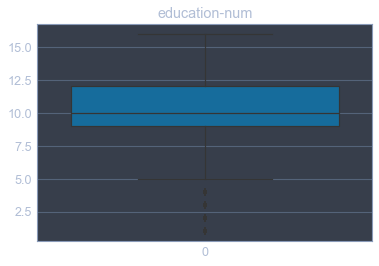

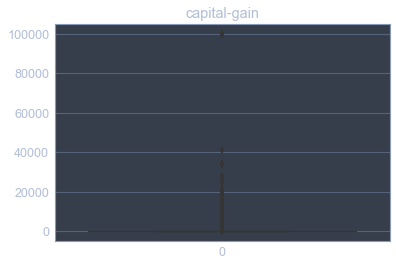

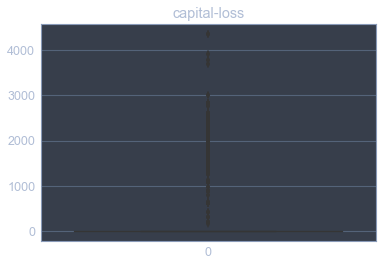

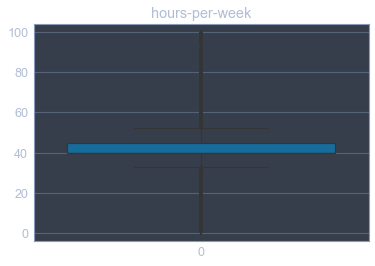

In [9]:
for j in not_null_columns:
    plt.figure()
    plt.title(j)
    sns.boxplot(data=df[j])

In [10]:
#вывод всех уникальных значений для каждой фичи
for j in df:
    uniq = np.unique(df[j].values)
    print(j+": "+str(len(uniq))+"\n"+str(uniq)+"\n")

age: 73
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 90]

workclass: 9
['?' 'Federal-gov' 'Local-gov' 'Never-worked' 'Private' 'Self-emp-inc'
 'Self-emp-not-inc' 'State-gov' 'Without-pay']

fnlwgt: 21648
[  12285   13769   14878 ... 1366120 1455435 1484705]

education: 16
['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college']

education-num: 16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

marital-status: 7
['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed']

occupation: 15
['?' 'Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv

In [11]:
#не совсем понятно, что за фича, поэтому дропну ее
df.drop('fnlwgt',axis = 1)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,makes_over_50K_a_year
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [12]:
to_review = []
to_review.append(["age", 17]) 
to_review.append(["occupation", "?"]) 
to_review.append(["workclass", "?"])
to_review.append(["capital-gain", 0])
to_review.append(["capital-gain", 99999])
to_review.append(["capital-loss", 0])
to_review.append(["native-country", "?"])

for j in to_review:
    print(j, (df[j[0]] == j[1]).sum())
df.shape

['age', 17] 395
['occupation', '?'] 1843
['workclass', '?'] 1836
['capital-gain', 0] 29849
['capital-gain', 99999] 159
['capital-loss', 0] 31042
['native-country', '?'] 583


(32561, 15)